In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.0 Importing dependencies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
import pickle
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import os
import random

tf.get_logger().setLevel('ERROR')
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


# 4.0 Model Building

In [ ]:
with open('/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/tomato.pkl', 'rb') as file:      
    # Call load method to deserialze
    tomato = pickle.load(file)

tomato.head()

,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
datetime,,,,,,
2017-05-14 12:55:15,33.0,33.0,1.0,445.0,26.3,18.0
2017-05-14 12:56:15,33.1,35.0,1.0,448.0,26.3,18.0
2017-05-14 12:57:15,33.0,33.0,1.0,443.0,26.3,18.0
2017-05-14 12:58:15,33.0,33.0,1.0,443.0,26.3,18.0
2017-05-14 12:59:15,32.8,33.0,1.0,448.0,26.3,18.0


In [ ]:
tomato.shape

(380434, 6)

### 4.1 Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### 4.2 Split data

In [ ]:
test_size = int(tomato.shape[0]*0.2)
X_train_raw = tomato.iloc[:-test_size]
X_test_raw = tomato.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


(304348, 6) (76086, 6)


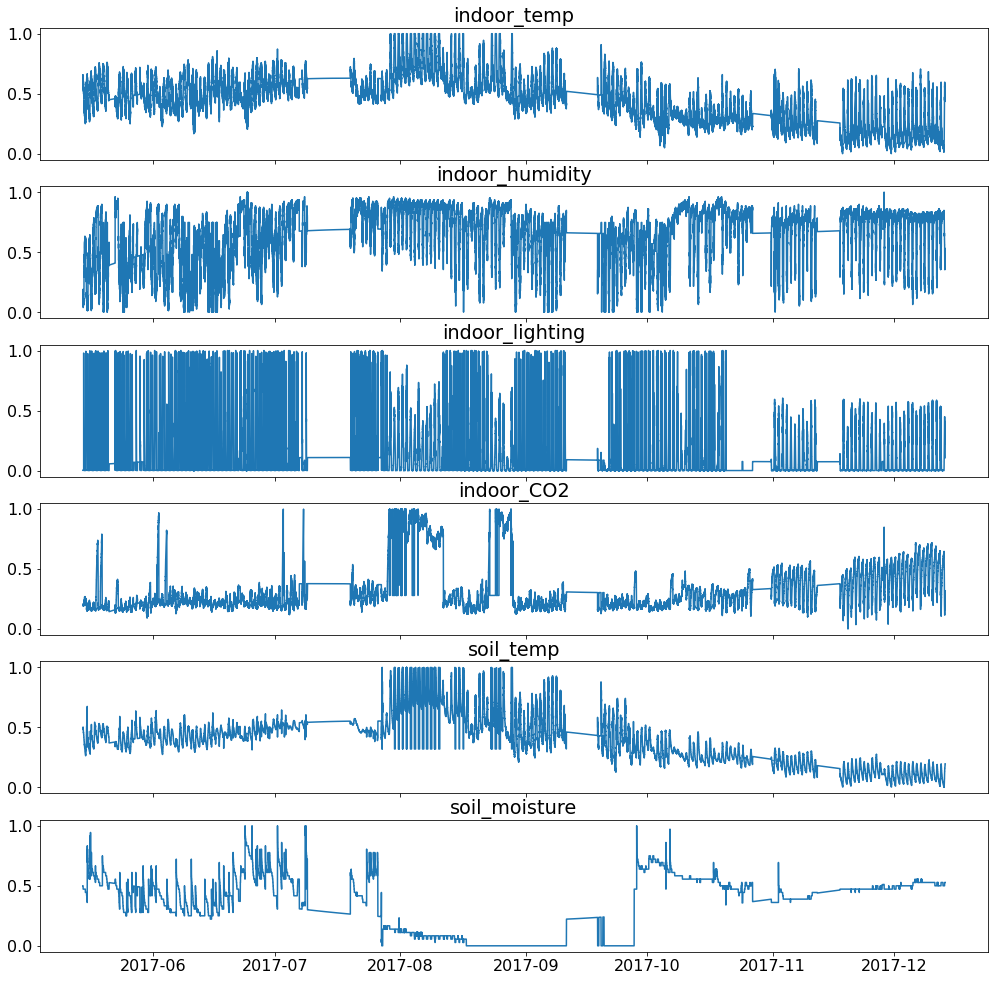

In [ ]:
figs, axs = plt.subplots(len(X_train_raw.columns), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(X_train_raw.columns):
    axs[i].plot(X_train_raw[col])
    axs[i].set_title(col)
plt.show()

In [ ]:
window = 1440 #no. of minutes in a day
stride = 5

In [ ]:
future = tomato[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 1440, 6)

In [ ]:
future_index = tomato[-window:].reset_index(drop = False)['datetime']

In [ ]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### 4.3 Multivariate Forecasting (Direct)

In [ ]:
target_labels = tomato.columns
telescope = 5 # forecast for next 5mins

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60767, 1440, 6) (60767, 5, 6)
(14975, 1440, 6) (14975, 5, 6)


In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[1,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        #axs[i].set_ylim(0,1)
    plt.show()

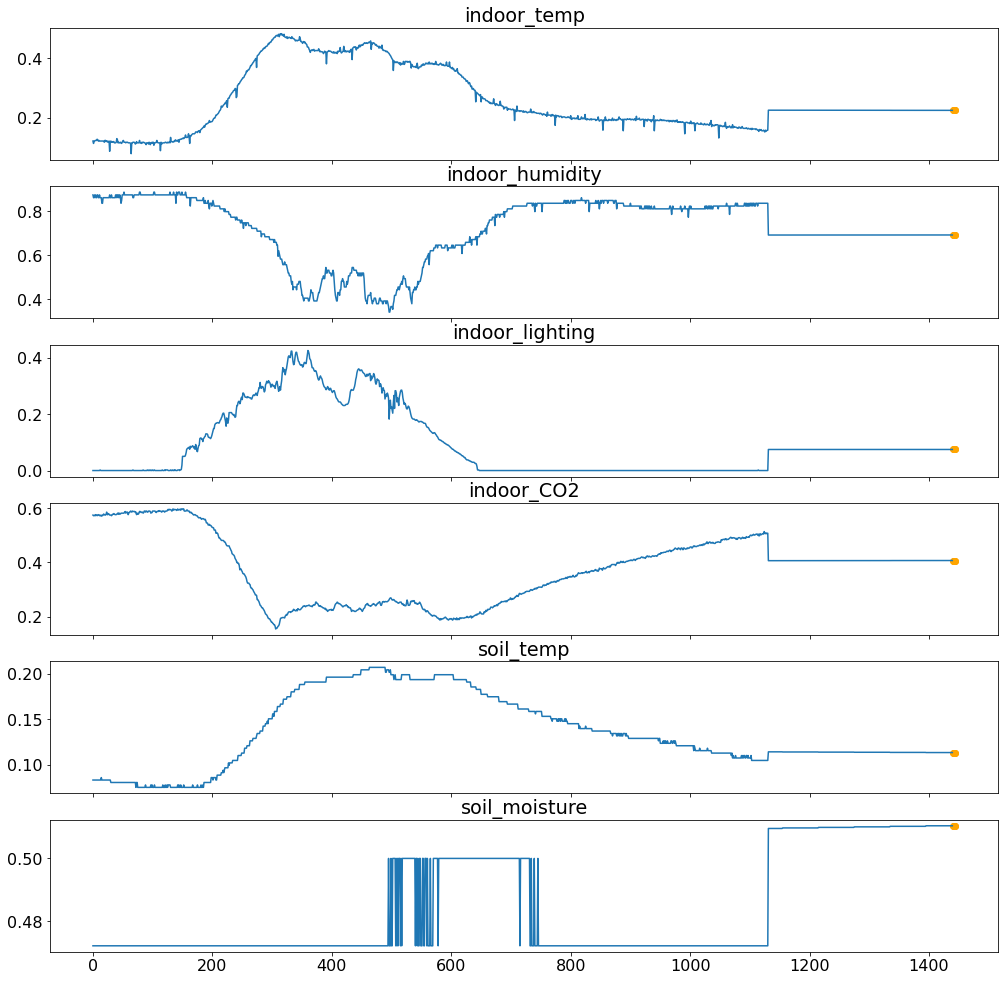

In [ ]:
#Visualize the train data
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 100

#### Implementation of attention layer

In [ ]:
from keras.layers import Layer
import keras.backend as K

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), 
                                            kernel_regularizer=tf.keras.regularizers.l2(1e-3)))(input_layer)
    convlstm = tfkl.Conv1D(128, 5, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), 
                                            kernel_regularizer=tf.keras.regularizers.l2(1e-3)))(convlstm)
    convlstm = tfkl.Conv1D(256, 5, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.4)(convlstm)
 
    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
 
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
 
    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
 
    # Return the model
    return model


In [ ]:
print(input_shape)
print(output_shape)

(1440, 6)
(5, 6)


In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1440, 6)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1440, 128)        36352     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 1440, 128)         82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 720, 128)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 720, 256)         263168    
 nal)                                                            
                                                             

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001, mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/100
428/428 [==============================] - 143s 301ms/step - loss: 0.0722 - mae: 0.1315 - val_loss: 0.0259 - val_mae: 0.1160 - lr: 0.0010
Epoch 2/100
428/428 [==============================] - 130s 304ms/step - loss: 0.0210 - mae: 0.0976 - val_loss: 0.0215 - val_mae: 0.1078 - lr: 0.0010
Epoch 3/100
428/428 [==============================] - 129s 302ms/step - loss: 0.0193 - mae: 0.0923 - val_loss: 0.0195 - val_mae: 0.1068 - lr: 0.0010
Epoch 4/100
428/428 [==============================] - 129s 302ms/step - loss: 0.0187 - mae: 0.0903 - val_loss: 0.0209 - val_mae: 0.1121 - lr: 0.0010
Epoch 5/100
428/428 [==============================] - 128s 299ms/step - loss: 0.0184 - mae: 0.0895 - val_loss: 0.0193 - val_mae: 0.1067 - lr: 0.0010
Epoch 6/100
428/428 [==============================] - 129s 300ms/step - loss: 0.0210 - mae: 0.0911 - val_loss: 0.0221 - val_mae: 0.1054 - lr: 0.0010
Epoch 7/100
428/428 [==============================] - 128s 300ms/step - loss: 0.0195 - mae: 0.0897 

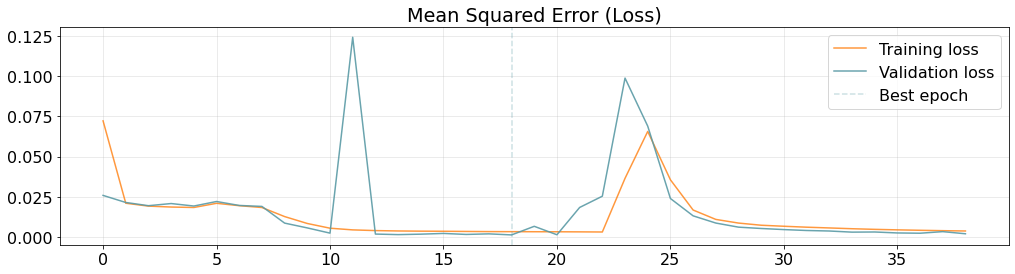

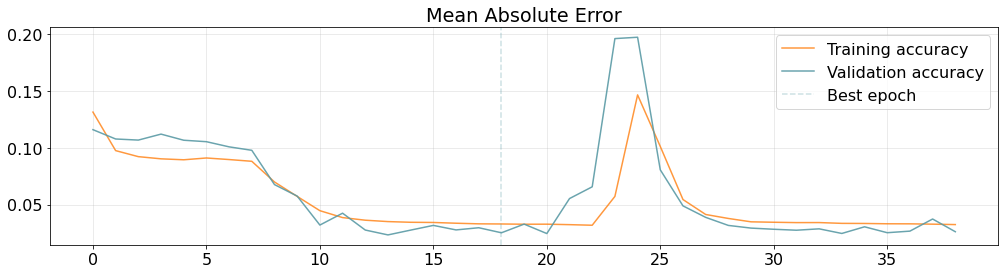

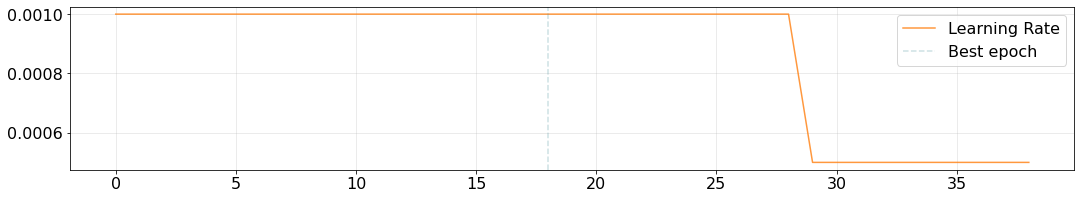

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save(r'/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/t0.h5')


In [ ]:
model = tfk.models.load_model('/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/t0.h5')

#### Test evaluation

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

468/468 [==============================] - 33s 67ms/step
(14975, 5, 6)


In [ ]:
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())

mean_absolute_error, mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.047787677>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.015043146>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[1,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

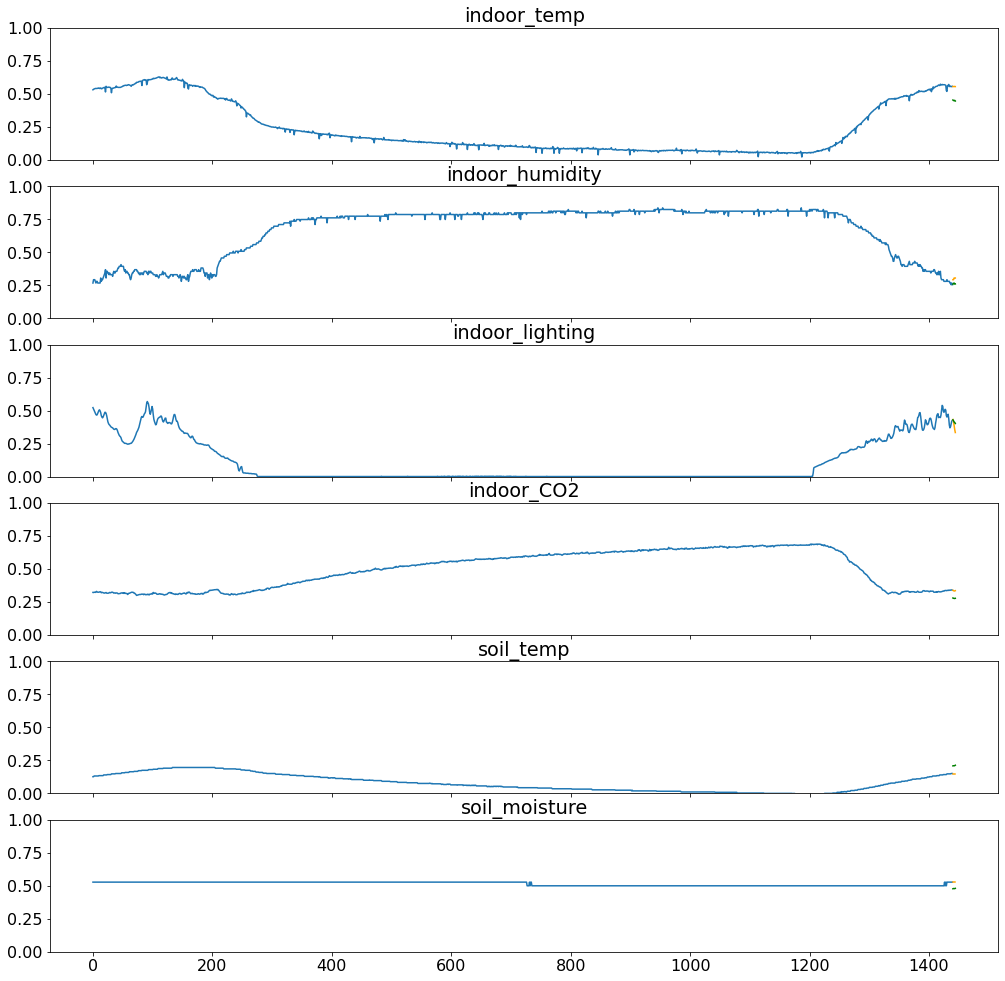

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)#, future_index)

#### Predict the future 

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

1/1 [==============================] - 0s 230ms/step


In [ ]:
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [ ]:
df_norm = pd.DataFrame(future_predictions.reshape(future_predictions[0].shape), columns = tomato.columns)

#removing normalizing
future_pred = round((df_norm* (X_max-X_min)) + X_min, 1)

#adding datetime index
last_time_stamp = tomato.reset_index()['datetime'][len(tomato)-1]
timestamplist = [last_time_stamp + timedelta(minutes=i) for i in range(1,telescope+1)]
future_pred['datetime'] = timestamplist
future_pred = future_pred.set_index('datetime')
future_pred

,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
datetime,,,,,,
2018-02-05 15:22:27,22.2,40.5,151.3,517.8,16.2,21.0
2018-02-05 15:23:27,22.1,40.8,149.0,514.7,16.2,21.0
2018-02-05 15:24:27,21.9,41.6,146.3,516.1,16.1,20.9
2018-02-05 15:25:27,22.1,40.6,146.5,513.8,16.2,21.0
2018-02-05 15:26:27,21.9,40.8,143.1,516.0,16.3,21.0


<function matplotlib.pyplot.show(*args, **kw)>

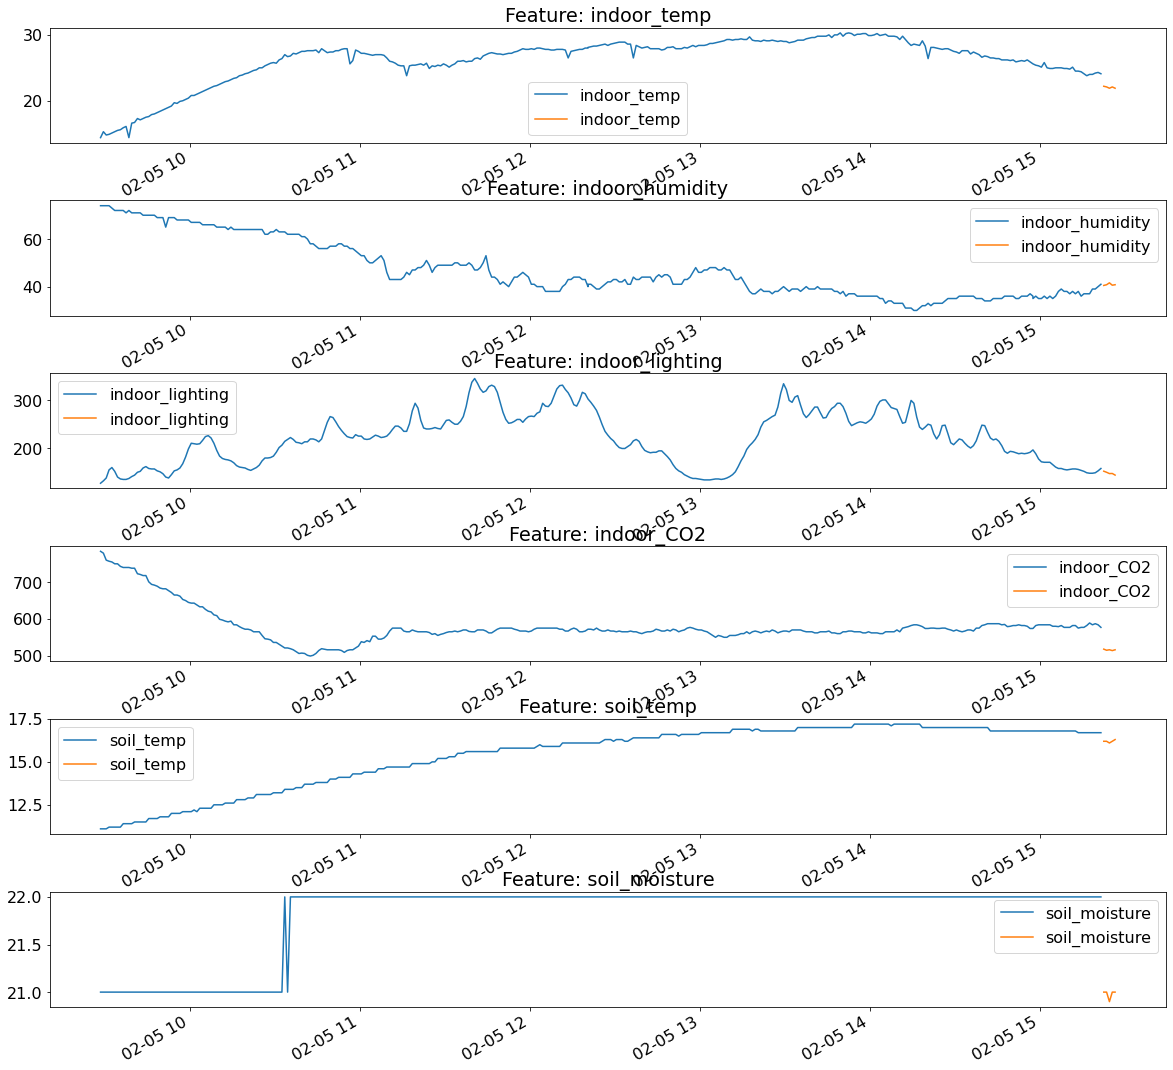

In [ ]:
bottom = tomato.tail(360)

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
#plt.suptitle("Comparison between Setpoints over Time", fontsize=18, y=0.90)

# loop through the length of tickers and keep track of index
for n in range(6):

    col_name = future_pred.columns[n]
    # add a new subplot iteratively
    ax = plt.subplot(6, 1, n + 1)

    # filter df and plot ticker on the new subplot axis
    bottom.iloc[:,n].plot(legend = col_name+' actual') 
    future_pred.iloc[:,n].plot(legend = col_name+' future')     
    plt.legend(loc = 'best')

    # chart formatting
    ax.set_title("Feature: {}".format(col_name))
    ax.set_xlabel("")
plt.show

### Ideal values:

- indoor temp: 18 to 27°C (Source: technical sheet)
- indoor humidity 70% (Source: technical sheet)
- indoor lighting - 400-500umole/m2 (Source: [link](https://www.enlitehorti.com/the-light-intensity-required-for-tomatoes.html#:~:text=The%20light%20requirements%20for%20growing%20tomatoes%20indoors%20is%20400%2D500umole,the%20increase%20of%20light%20intensity.))
- CO2 concentration 400 to 1000 ppm (Source: [link](https://www.vegetables.bayer.com/au/en-au/resources/growing-tips/cultivation-insights/managing-light-and-co2-for-tomatoes-in-protected-culture.html))
- Soil temperature - 20 - 25°C (Source: technical sheet)
- Soil moisture - 10-25% (Source: as per the values in dataset, need ideal values)

# 5.0 Deployment

In [ ]:
future_data = pd.read_csv(r'/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/future.csv')
future_data.head()

,date,time,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
0,12:55:15,5/14/2017,33.0,33,2500,445,26.3,18
1,12:56:15,5/14/2017,33.1,35,2500,448,26.3,18
2,12:57:15,5/14/2017,33.0,33,2500,443,26.3,18
3,12:58:15,5/14/2017,33.0,33,2500,443,26.3,18
4,12:59:15,5/14/2017,32.8,33,2500,448,26.3,18


In [ ]:
X_normalized_values = pd.DataFrame({
 'X_max' : [50.0, 100.0, 477.0, 1473.0, 45.4, 36.0],
 'X_min' : [0.7, 21.0, 0.0, 188.0, 8.2, 0.0],
 'parameters' : ['indoor_temp', 'indoor_humidity', 'indoor_lighting', 'indoor_CO2', 'soil_temp', 'soil_moisture']   
})

X_normalized_values = X_normalized_values.set_index('parameters')
X_normalized_values

,X_max,X_min
parameters,,
indoor_temp,50.0,0.7
indoor_humidity,100.0,21.0
indoor_lighting,477.0,0.0
indoor_CO2,1473.0,188.0
soil_temp,45.4,8.2
soil_moisture,36.0,0.0


## 5.1 Preprocessing

In [ ]:
future_data['datetime'] = pd.to_datetime(future_data['date'] + ' ' + future_data['time'])
future_data['datetime'] = pd.to_datetime(future_data['datetime'], format='%d.%m.%Y %H:%M:%S')
future_data = future_data.drop(['date', 'time'], axis = 1)
future_data = future_data.set_index('datetime')
future_data.head()

,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
datetime,,,,,,
2017-05-14 12:55:15,33.0,33,2500,445,26.3,18
2017-05-14 12:56:15,33.1,35,2500,448,26.3,18
2017-05-14 12:57:15,33.0,33,2500,443,26.3,18
2017-05-14 12:58:15,33.0,33,2500,443,26.3,18
2017-05-14 12:59:15,32.8,33,2500,448,26.3,18


## 5.2 Normalizing

In [ ]:
future = (future_data-X_normalized_values['X_min'])/(X_normalized_values['X_max']-X_normalized_values['X_min'])
future = np.expand_dims(future, axis=0)
future.shape

(1, 1440, 6)

In [ ]:
future[0]

array([[0.65517241, 0.15189873, 5.24109015, 0.2       , 0.48655914,
        0.5       ],
       [0.65720081, 0.17721519, 5.24109015, 0.20233463, 0.48655914,
        0.5       ],
       [0.65517241, 0.15189873, 5.24109015, 0.19844358, 0.48655914,
        0.5       ],
       ...,
       [0.62880325, 0.11392405, 5.24109015, 0.16031128, 0.5       ,
        0.38888889],
       [0.62677485, 0.13924051, 5.24109015, 0.15642023, 0.50268817,
        0.38888889],
       [0.62677485, 0.12658228, 5.24109015, 0.15252918, 0.50268817,
        0.38888889]])

## 5.3 Prediction

In [ ]:
model = tfk.models.load_model('/content/drive/MyDrive/Data Science Projects/Algeria Greenhouse Project/model_1D_win_5Stride.h5')

In [ ]:
future_predictions = model.predict(future)

1/1 [==============================] - 2s 2s/step


## 5.4 Post-processing

In [ ]:
df_norm = pd.DataFrame(future_predictions.reshape(future_predictions[0].shape), columns = future_data.columns)

#removing normalizing
future_pred = round((df_norm* (X_normalized_values['X_max']-X_normalized_values['X_min'])) + X_normalized_values['X_min'], 1)

#adding datetime index
last_time_stamp = future_data.reset_index()['datetime'][len(future_data)-1]
timestamplist = [last_time_stamp + timedelta(minutes=i) for i in range(1,6)]
future_pred['datetime'] = timestamplist
future_pred = future_pred.set_index('datetime')
future_pred

,indoor_temp,indoor_humidity,indoor_lighting,indoor_CO2,soil_temp,soil_moisture
datetime,,,,,,
2017-05-15 13:09:12,22.8,49.8,369.3,356.5,20.3,19.0
2017-05-15 13:10:12,22.6,49.4,358.8,354.6,20.2,19.1
2017-05-15 13:11:12,31.0,56.0,316.8,304.9,14.9,18.9
2017-05-15 13:12:12,22.5,48.8,337.6,358.6,19.8,19.4
2017-05-15 13:13:12,22.3,48.8,329.8,359.6,19.6,19.6


<function matplotlib.pyplot.show(*args, **kw)>

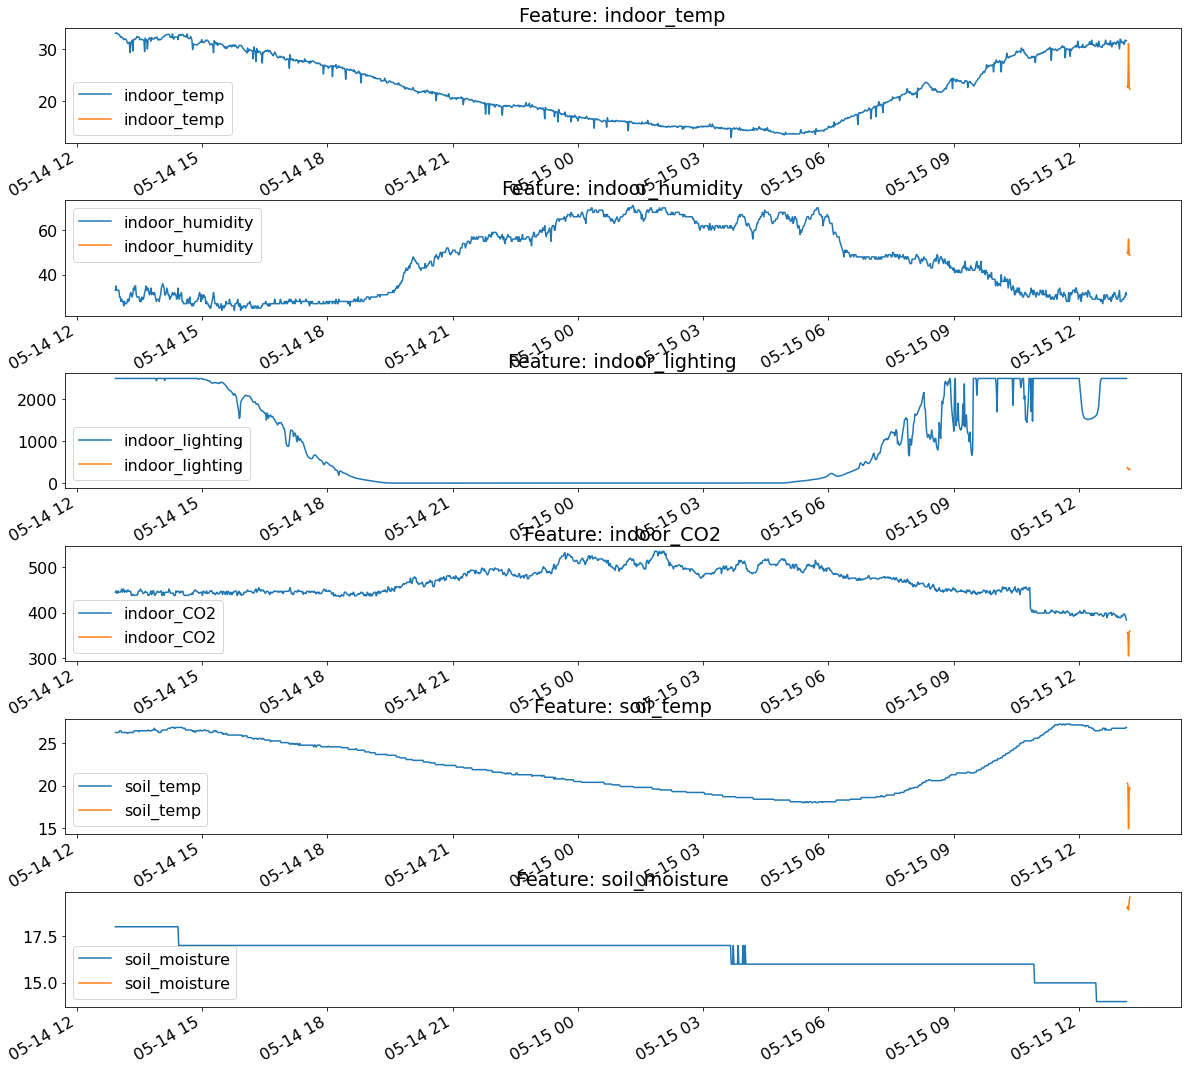

In [ ]:
bottom = future_data

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
#plt.suptitle("Comparison between Setpoints over Time", fontsize=18, y=0.90)

# loop through the length of tickers and keep track of index
for n in range(6):

    col_name = future_pred.columns[n]
    # add a new subplot iteratively
    ax = plt.subplot(6, 1, n + 1)

    # filter df and plot ticker on the new subplot axis
    future_data.iloc[:,n].plot() 
    future_pred.iloc[:,n].plot()     
    plt.legend(loc = 'best')

    # chart formatting
    ax.set_title("Feature: {}".format(col_name))
    ax.set_xlabel("")
plt.show